**Project Summary: Time Series Forecasting for Vehicle Sales**

This project involved analyzing and forecasting time series data related to vehicle sales. The conversation began with filtering the data to extract relevant information, such as sales data for new motor vehicles in Canada. Various techniques were discussed, including seasonal decomposition, stationarity testing using the Augmented Dickey-Fuller test, and forecasting using models like ARIMA, SARIMA, ETS, and Prophet.

The analysis focused on evaluating the performance of different forecasting models in predicting future sales. Mean squared error (MSE) and mean absolute error (MAE) were used as evaluation metrics, alongside visualizations such as line graphs to compare predicted values with actual sales data.

The project concluded with plotting the last 30 days of forecasted sales values for each model, providing a visual representation of their performance in capturing the recent trends in vehicle sales.

Overall, the project demonstrated the application of various time series forecasting techniques and models to predict vehicle sales, providing valuable insights for decision-making in the automotive industry.

--- 

This summary captures the key aspects of the project, including data preprocessing, model selection, evaluation metrics, and visualization of results.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dateutil.relativedelta import relativedelta


In [6]:
# Define the file path for the dataset
data_path = r'C:\Users\yeswa\OneDrive\Desktop\time_series\data\New motor vehicle sales - Dataset\new_motor_vechicle_sales.csv'


In [7]:
# Read the dataset into a DataFrame
motor_sales_df = pd.read_csv(data_path, low_memory=False)

# Display the first two rows of the DataFrame
motor_sales_df.head(2)

,REF_DATE,GEO,DGUID,Vehicle type,Origin of manufacture,Sales,Seasonal adjustment,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1946-01,Canada,2016A000011124,"Total, new motor vehicles","Total, country of manufacture",Units,Unadjusted,Units,300,units,0,v42169911,1.1.1.1.1,2756.0,NaN,NaN,NaN,0
1,1946-01,Canada,2016A000011124,"Total, new motor vehicles","Total, country of manufacture",Dollars,Unadjusted,Dollars,81,thousands,3,v42169913,1.1.1.2.1,4507.0,NaN,NaN,NaN,0


In [8]:
# Retrieve the shape of the DataFrame (number of rows and columns)
motor_sales_df.shape


(160506, 18)

### Data Filtering for Canadian New Motor Vehicle Sales

#### Description:
This code snippet demonstrates how to filter a DataFrame to extract data specifically related to new motor vehicle sales in Canada. The DataFrame contains various columns such as geographical location, vehicle type, origin of manufacture, sales measurement units, and seasonal adjustment. By applying multiple filters, the code selects only the rows that match the criteria for Canada, total new motor vehicles, total country of manufacture, sales measured in units, and unadjusted seasonal data.


In [9]:
# Filter for data from Canada
condition_filter_1 = motor_sales_df['GEO'] == "Canada"

# Filter for data on total new motor vehicles
condition_filter_2 = motor_sales_df['Vehicle type'] == "Total, new motor vehicles"

# Filter for data on total country of manufacture
condition_filter_3 = motor_sales_df['Origin of manufacture'] == "Total, country of manufacture"

# Filter for data measured in units
condition_filter_4 = motor_sales_df['Sales'] == "Units"

# Filter for unadjusted seasonal data
condition_filter_5 = motor_sales_df['Seasonal adjustment'] == "Unadjusted"

# Apply all the filters to the DataFrame
canadian_vehicle_sales_df_filtered = motor_sales_df.loc[(condition_filter_1) & 
            (condition_filter_2) & 
            (condition_filter_3) & 
            (condition_filter_4) & 
            (condition_filter_5)]


In [10]:
# Retrieve the shape of the filtered DataFrame (number of rows and columns)
canadian_vehicle_sales_df_filtered.shape

(936, 18)

In [11]:
canadian_vehicle_sales_df_filtered.head(1)

,REF_DATE,GEO,DGUID,Vehicle type,Origin of manufacture,Sales,Seasonal adjustment,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1946-01,Canada,2016A000011124,"Total, new motor vehicles","Total, country of manufacture",Units,Unadjusted,Units,300,units,0,v42169911,1.1.1.1.1,2756.0,NaN,NaN,NaN,0


In [12]:
# Reset the index and extract REF_DATE and VALUE columns
extracted_columns_df = canadian_vehicle_sales_df_filtered.loc[:, ['REF_DATE', 'VALUE']].reset_index(drop=True)

# Display the first five rows of the extracted DataFrame
extracted_columns_df.head(5)

,REF_DATE,VALUE
0,1946-01,2756.0
1,1946-02,3763.0
2,1946-03,7200.0
3,1946-04,9645.0
4,1946-05,12032.0


In [13]:
# Display the last five rows of the extracted DataFrame
extracted_columns_df.tail(5)

,REF_DATE,VALUE
931,2023-08,158531.0
932,2023-09,163187.0
933,2023-10,151144.0
934,2023-11,143723.0
935,2023-12,128193.0


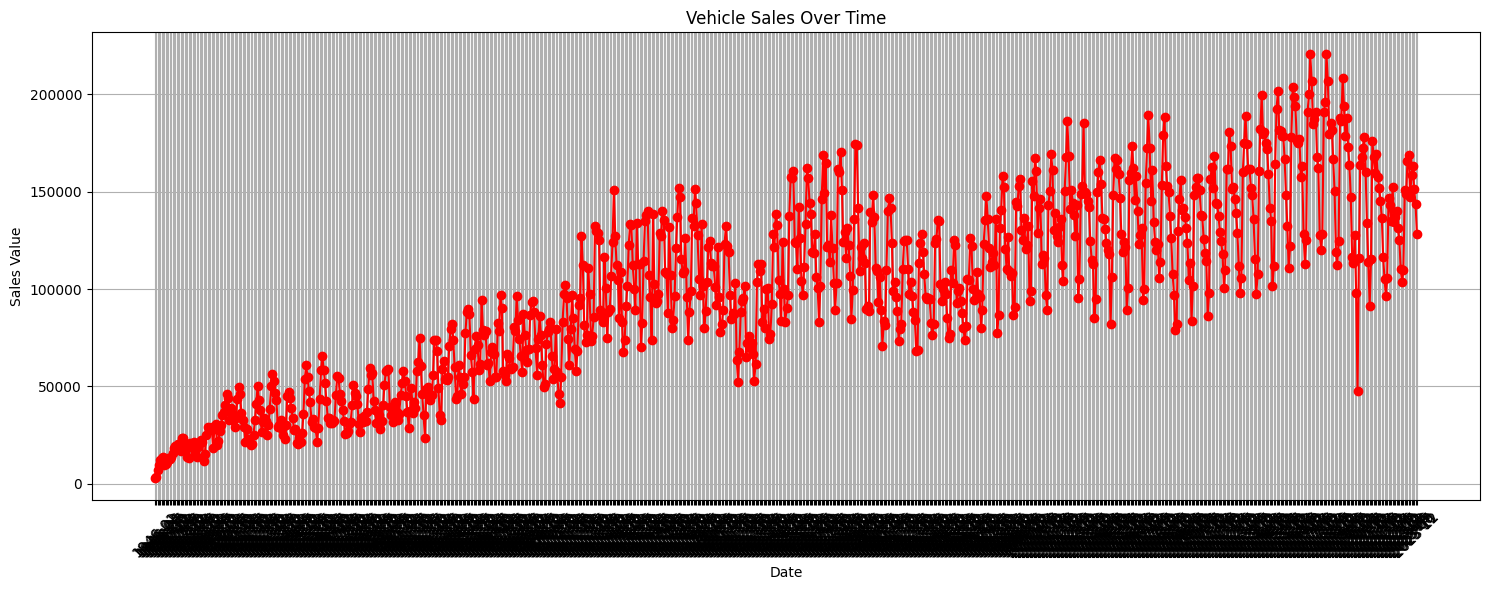

In [14]:
# Extract REF_DATE and VALUE columns from the extracted DataFrame
REF_DATE = extracted_columns_df['REF_DATE']
VALUE = extracted_columns_df['VALUE']

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(REF_DATE, VALUE, marker='o', color='r', linestyle='-')
plt.title('Vehicle Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
# Generate descriptive statistics for the extracted DataFrame
extracted_columns_df.describe()

,VALUE
count,936.000000
mean,98749.572650
std,47496.556125
min,2756.000000
25%,58671.000000
50%,100234.000000
75%,134845.750000
max,220858.000000


#### seasonal_decompose

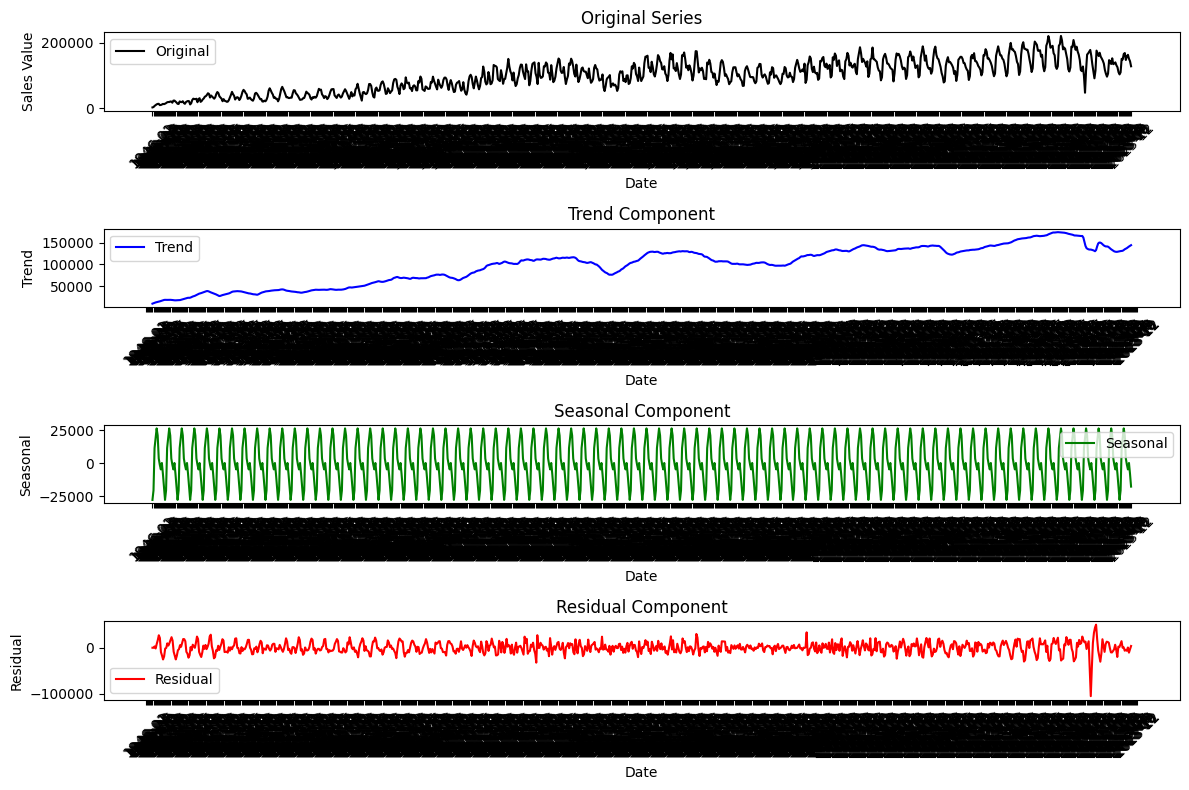

In [16]:
# Data
REF_DATE = extracted_columns_df['REF_DATE']
VALUE = extracted_columns_df['VALUE']

# Perform seasonal decomposition
result = seasonal_decompose(VALUE, model='additive', period=12)  # Assuming a yearly seasonality with a period of 12 months

# Plot decomposition components
plt.figure(figsize=(12, 8))

# Original series
plt.subplot(411)
plt.plot(REF_DATE, VALUE, label='Original', color='black')
plt.title('Original Series')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)
plt.legend()

# Trend component
plt.subplot(412)
plt.plot(REF_DATE, result.trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)
plt.legend()

# Seasonal component
plt.subplot(413)
plt.plot(REF_DATE, result.seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.xticks(rotation=45)
plt.legend()

# Residual component
plt.subplot(414)
plt.plot(REF_DATE, result.resid, label='Residual', color='red')
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


#### Augmented Dickey-Fuller (ADF) 

In [17]:
# Extract the 'VALUE' column from the DataFrame
sales_values = extracted_columns_df['VALUE']

# Perform Augmented Dickey-Fuller test
result_adf = adfuller(sales_values)

# Extracting test results
adf_statistic = result_adf[0]
p_value = result_adf[1]
critical_values = result_adf[4]

# Print test results
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"    {key}: {value}")

# Interpret test results
if p_value < 0.05:
    print("Reject the null hypothesis. The data is stationary.")
else:
    print("Fail to reject the null hypothesis. The data is not stationary.")


ADF Statistic: -1.5788337855620962
p-value: 0.49421665845435414
Critical Values:
    1%: -3.437524792681557
    5%: -2.8647073745235074
    10%: -2.568456513461879
Fail to reject the null hypothesis. The data is not stationary.


When interpreting the results of the Augmented Dickey-Fuller (ADF) test:

1. **ADF Statistic**: This is the test statistic. In this case, it's -1.5788.

2. **p-value**: This is the probability value associated with the test statistic. In this case, it's approximately 0.4942.

3. **Critical Values**: These are the critical values for different levels of significance (1%, 5%, and 10%). They are thresholds that help determine the significance of the test statistic. In this case, they are -3.4375, -2.8647, and -2.5685 respectively.

4. **Interpretation**: 
   - If the p-value is less than a chosen significance level (e.g., 0.05), we reject the null hypothesis. It indicates strong evidence against the null hypothesis, suggesting that the data is stationary.
   - If the p-value is greater than the significance level, we fail to reject the null hypothesis. It suggests weak evidence against the null hypothesis, and we cannot conclude that the data is stationary.

In your case, the p-value (0.4942) is greater than the common significance level of 0.05. Therefore, you fail to reject the null hypothesis. This implies that there is not enough evidence to conclude that the data is stationary. The data likely exhibits some form of non-stationarity. Further analysis or transformation may be necessary to address this.

#### Check for missing months

In [18]:
# Generate a range of dates from the minimum to maximum date in REF_DATE
date_range = pd.date_range(start=extracted_columns_df['REF_DATE'].min(), end=extracted_columns_df['REF_DATE'].max(), freq='MS')

# Convert the range of dates to a list of month strings in the format 'YYYY-MM'
expected_months = [date.strftime('%Y-%m') for date in date_range]

# Extract existing months from the REF_DATE column
existing_months = extracted_columns_df['REF_DATE'].tolist()

# Find missing months
missing_months = [month for month in expected_months if month not in existing_months]

print("Missing months:")
for month in missing_months:
    print(month)


Missing months:


The code efficiently compares the range of expected months with the existing months in the dataset, revealing that there are no missing months in the `REF_DATE` column, ensuring a complete and continuous time series.

#### Univariant timeseries models

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

def forecast_monthly_sales(data, column_name, forecast_horizon=6, window_size=920):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of months to forecast. Default is 6.
    window_size (int): Size of the sliding window for backtesting in months. Default is 6.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Convert the date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])

    # Aggregate the data into monthly sums
    data.set_index('date', inplace=True)
    data = data.resample('MS').sum().reset_index()

    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=920, forecast_horizon=6):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of months to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        cumulative_length = 0  # Initialize cumulative length counter

        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            cumulative_length += len(train)
            print(f"Length of training data in iteration {i+1}: {len(train)}, Cumulative length: {cumulative_length}")
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        try:
            order = (1, 1, 1)  # Simpler (p, d, q)
            seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
            model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        except np.linalg.LinAlgError:
            print("SARIMAX model fitting failed due to LinAlgError")
            return np.zeros(len(test))

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        seasonal_periods = 12  # Monthly seasonality
        if len(train) >= 2 * seasonal_periods:
            model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=seasonal_periods)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        else:
            print("Not enough data for ETS model")
            return np.zeros(len(test))

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test), freq='MS')
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        if len(series) < 10:
            print("Not enough data for LSTM model")
            return np.zeros(len(test))
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of months to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            if isinstance(forecast_values, np.ndarray):
                forecast_df[model] = scaler.inverse_transform(forecast_values.reshape(-1, 1)).flatten().astype(int)
            else:
                forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


In [20]:
# Load the data
data = extracted_columns_df.copy() 

# Rename the column
data.rename(columns={'REF_DATE': 'date'}, inplace=True)

# Call the function
monthly_sales_result = forecast_monthly_sales(data, 'VALUE')

# Print the results
print("Backtesting Error Metrics:")
print(monthly_sales_result['error_metrics'])

print("Final Forecasts for the next 6 months:")
print(monthly_sales_result['forecasts'])

Length of training data in iteration 1: 920, Cumulative length: 920


08:50:43 - cmdstanpy - INFO - Chain [1] start processing
08:50:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 2: 920, Cumulative length: 1840


08:52:03 - cmdstanpy - INFO - Chain [1] start processing
08:52:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 3: 920, Cumulative length: 2760


08:53:16 - cmdstanpy - INFO - Chain [1] start processing
08:53:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 4: 920, Cumulative length: 3680


08:54:27 - cmdstanpy - INFO - Chain [1] start processing
08:54:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 5: 920, Cumulative length: 4600


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
08:55:40 - cmdstanpy - INFO - Chain [1] start processing
08:55:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these argum

Length of training data in iteration 6: 920, Cumulative length: 5520


08:56:51 - cmdstanpy - INFO - Chain [1] start processing
08:56:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 7: 920, Cumulative length: 6440


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
08:58:13 - cmdstanpy - INFO - Chain [1] start processing
08:58:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these argum

Length of training data in iteration 8: 920, Cumulative length: 7360


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
08:59:34 - cmdstanpy - INFO - Chain [1] start processing
08:59:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these argum

Length of training data in iteration 9: 920, Cumulative length: 8280


09:00:51 - cmdstanpy - INFO - Chain [1] start processing
09:00:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 10: 920, Cumulative length: 9200


09:02:04 - cmdstanpy - INFO - Chain [1] start processing
09:02:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Length of training data in iteration 11: 920, Cumulative length: 10120


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
09:03:17 - cmdstanpy - INFO - Chain [1] start processing
09:03:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these argum

Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    0.105059  0.014795
SARIMA   0.054085  0.003654
ETS      0.064058  0.006206
Prophet  0.086841  0.009545
LSTM     0.092805  0.012743
Final Forecasts for the next 6 months:
             ARIMA  SARIMA     ETS  Prophet    LSTM
Date                                               
2024-01-01  129061  110348  106560   130961  121134
2024-02-01  135365  117794  116902   138361  116466
2024-03-01  140199  159284  159165   171156  119607
2024-04-01  143285  155935  157005   176614  130750
2024-05-01  141871  170359  175780   185600  130700
2024-06-01  139020  174265  186540   179847  134100


#### plot forecast values

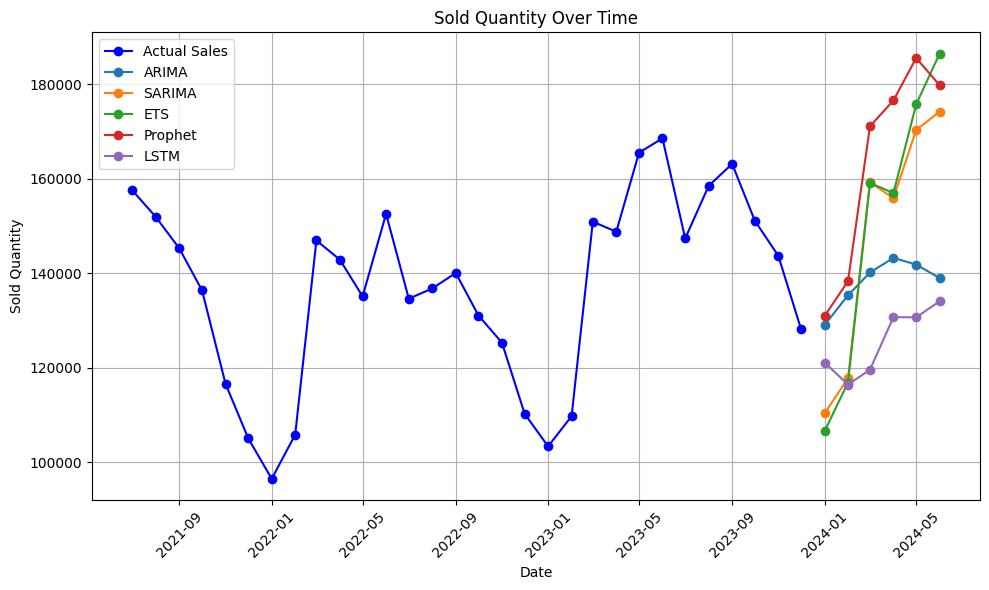

In [21]:
# Convert REF_DATE to datetime if not already in datetime format
extracted_columns_df['REF_DATE'] = pd.to_datetime(extracted_columns_df['REF_DATE'])

# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

# Extract last 30 records
last_30_days_df = extracted_columns_df.tail(30)

# Plot original sales data
plt.plot(last_30_days_df['REF_DATE'], last_30_days_df['VALUE'], marker='o', linestyle='-', color='b', label='Actual Sales')

# Plot each model's forecasted values
for col in monthly_sales_result['forecasts'].columns:
    plt.plot(monthly_sales_result['forecasts'].index, monthly_sales_result['forecasts'][col], marker='o', linestyle='-', label=col)

# Formatting
plt.title('Sold Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Sold Quantity')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()